In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ruta a tu carpeta "por_muestras"
RUTA_LOGS = ""

ARCHIVOS_LOGS = {
    "ecoli":      "log_pcsmote_x_muestra_ecoli.xlsx",
    "glass":      "log_pcsmote_x_muestra_glass.xlsx",
    "heart":      "log_pcsmote_x_muestra_heart.xlsx",
    "us_crime":   "log_pcsmote_x_muestra_us_crime.xlsx",
    "wdbc":       "log_pcsmote_x_muestra_wdbc.xlsx",
}

def cargar_logs_por_dataset():
    registros = []
    for nombre_ds, fname in ARCHIVOS_LOGS.items():
        ruta = os.path.join(RUTA_LOGS, fname)
        if not os.path.isfile(ruta):
            print(f"⚠️ No existe {ruta}, se omite.")
            continue
        df = pd.read_excel(ruta)
        df["dataset"] = nombre_ds
        registros.append(df)
        print(f"✅ Cargado log por muestra para {nombre_ds} ({len(df)} filas)")
    if not registros:
        raise RuntimeError("No se cargó ningún log.")
    return pd.concat(registros, ignore_index=True)

df_logs = cargar_logs_por_dataset()
df_logs.head()


✅ Cargado log por muestra para ecoli (2177 filas)
✅ Cargado log por muestra para glass (1368 filas)
✅ Cargado log por muestra para heart (1619 filas)
✅ Cargado log por muestra para us_crime (2160 filas)
✅ Cargado log por muestra para wdbc (3060 filas)


,configuracion,idx_global,clase_objetivo,es_semilla_valida,k,valor_percentil_dist,valor_umbral_densidad,valor_percentil_entropia,valor_percentil_riesgo,umbral_densidad,...,proporcion_min,pasa_pureza,pasa_densidad,pasa_riesgo,vecinos_validos_por_percentil,thr_dist_percentil,synthetics_from_this_seed,last_delta,last_neighbor_z,dataset
0,D25_R25_entropia_I0,0,1,True,7,0.957491,0.428571,0.863121,0.142857,0.428571,...,NaN,False,True,True,5,0.848550,1,0.597377,175.0,ecoli
1,D25_R25_entropia_I0,2,1,True,7,0.957491,0.428571,0.863121,0.142857,0.428571,...,NaN,False,True,True,5,0.604222,2,0.436681,139.0,ecoli
2,D25_R25_entropia_I0,5,1,True,7,0.957491,0.428571,0.863121,0.142857,0.428571,...,NaN,False,True,True,5,0.908425,2,0.544346,0.0,ecoli
3,D25_R25_entropia_I0,11,1,True,7,0.957491,0.428571,0.863121,0.142857,0.428571,...,NaN,True,False,True,5,1.220260,1,0.593126,189.0,ecoli
4,D25_R25_entropia_I0,12,1,True,7,0.957491,0.428571,0.863121,0.142857,0.428571,...,NaN,True,True,True,5,0.497262,1,0.471693,121.0,ecoli


In [19]:
def generar_panel_por_dataset(df_dataset, dataset, configs_interes=None, guardar=True):
    """
    df_dataset: df_logs filtrado a un dataset (col 'dataset')
    configs_interes: lista opcional de configuraciones exactas (strings)
                     ej: ["D50_R75_proporcion_I0","D75_R75_proporcion_I0"]
    """
    grupo_synt = (
        df_dataset
        .groupby("configuracion")["synthetics_from_this_seed"]
        .sum()
        .sort_values(ascending=False)
    )
    configs_ordenadas = list(grupo_synt.index)

    if configs_interes is None:
        # por defecto: top-8 configs con más sintéticas
        configs_plot = configs_ordenadas[:8]
    else:
        configs_plot = [c for c in configs_interes if c in configs_ordenadas]
        if not configs_plot:
            configs_plot = configs_ordenadas[:8]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"PC-SMOTE por muestra – {dataset}", fontsize=14)

    # --- 1) Sintéticas por configuración ---
    ax = axes[0, 0]
    ax.bar(range(len(configs_plot)), [grupo_synt[c] for c in configs_plot])
    ax.set_xticks(range(len(configs_plot)))
    ax.set_xticklabels(configs_plot, rotation=45, ha="right")
    ax.set_ylabel("Sintéticas totales")
    ax.set_title("Sintéticas generadas por configuración")

    # --- 2) Densidad (semillas válidas) ---
    ax = axes[0, 1]
    datos_box = []
    labels_box = []
    for cfg in configs_plot:
        sub = df_dataset[(df_dataset["configuracion"] == cfg) &
                         (df_dataset["es_semilla_valida"])]
        if not sub.empty:
            datos_box.append(sub["densidad"].values)
            labels_box.append(cfg)
    if datos_box:
        positions = list(range(1, len(labels_box) + 1))
        ax.boxplot(datos_box, positions=positions)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels_box, rotation=45, ha="right")
        ax.set_ylabel("Densidad (semillas válidas)")
        ax.set_title("Distribución de densidad por configuración")

    # --- 3) Riesgo (semillas válidas) ---
    ax = axes[1, 0]
    datos_box2 = []
    labels_box2 = []
    for cfg in configs_plot:
        sub = df_dataset[(df_dataset["configuracion"] == cfg) &
                         (df_dataset["es_semilla_valida"])]
        if not sub.empty:
            datos_box2.append(sub["riesgo"].values)
            labels_box2.append(cfg)
    if datos_box2:
        positions = list(range(1, len(labels_box2) + 1))
        ax.boxplot(datos_box2, positions=positions)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels_box2, rotation=45, ha="right")
        ax.set_ylabel("Riesgo (semillas válidas)")
        ax.set_title("Distribución de riesgo por configuración")

    # --- 4) Densidad vs Riesgo (semillas válidas) ---
    ax = axes[1, 1]
    for cfg in configs_plot:
        sub = df_dataset[(df_dataset["configuracion"] == cfg) &
                         (df_dataset["es_semilla_valida"])]
        if sub.empty:
            continue
        ax.scatter(sub["densidad"], sub["riesgo"], label=cfg, alpha=0.7)
    ax.set_xlabel("Densidad")
    ax.set_ylabel("Riesgo")
    ax.set_title("Densidad vs riesgo (semillas válidas)")
    ax.legend(fontsize=7)

    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if guardar:
        nombre = f"panel_pcsmote_{dataset}.png"
        fig.savefig(nombre, dpi=150)
        print(f"💾 Guardado {nombre}")

    return fig



=== Dataset: ecoli ===
💾 Guardado panel_pcsmote_ecoli.png

=== Dataset: glass ===
💾 Guardado panel_pcsmote_glass.png

=== Dataset: heart ===
💾 Guardado panel_pcsmote_heart.png

=== Dataset: us_crime ===
💾 Guardado panel_pcsmote_us_crime.png

=== Dataset: wdbc ===
💾 Guardado panel_pcsmote_wdbc.png


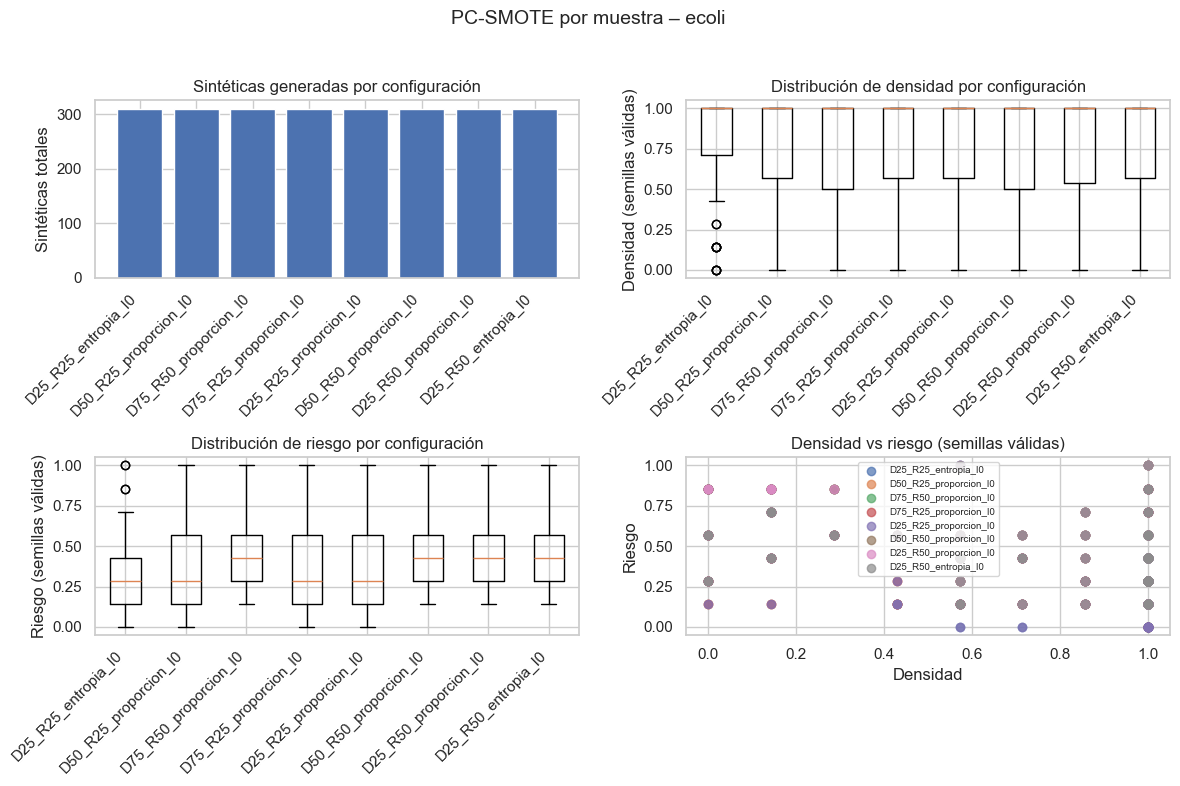

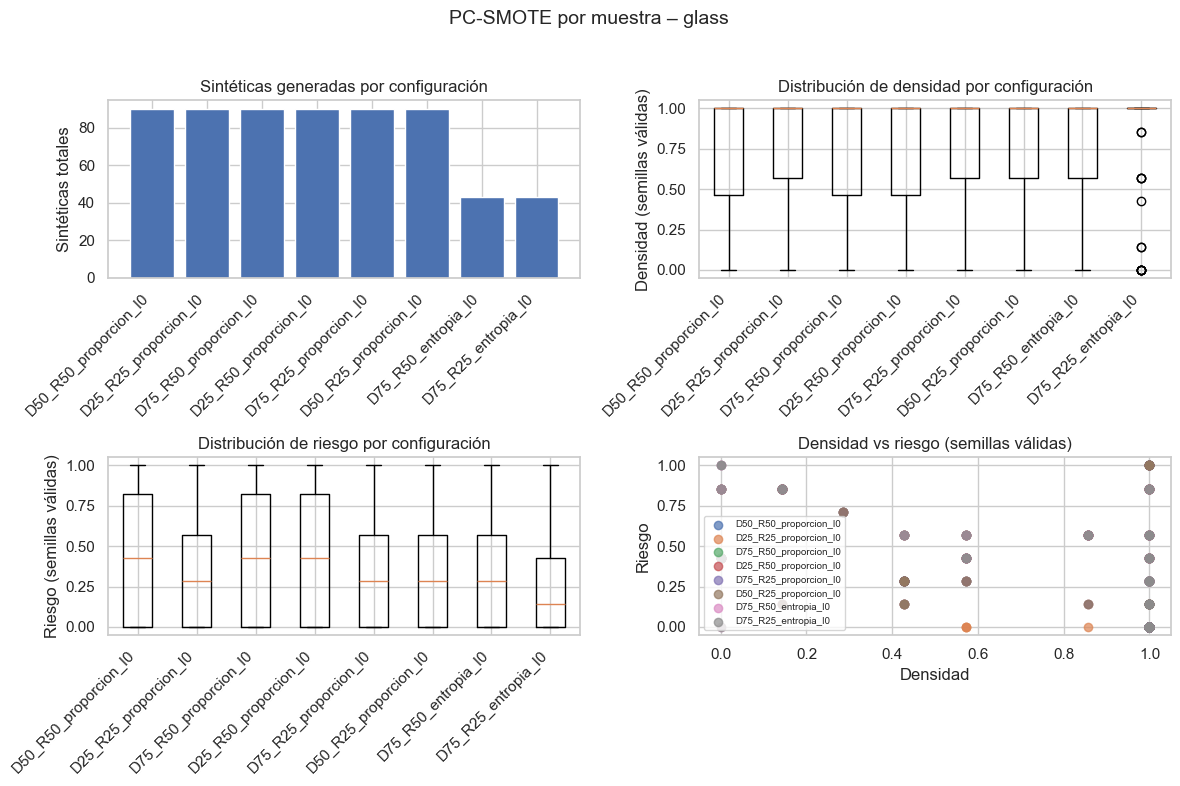

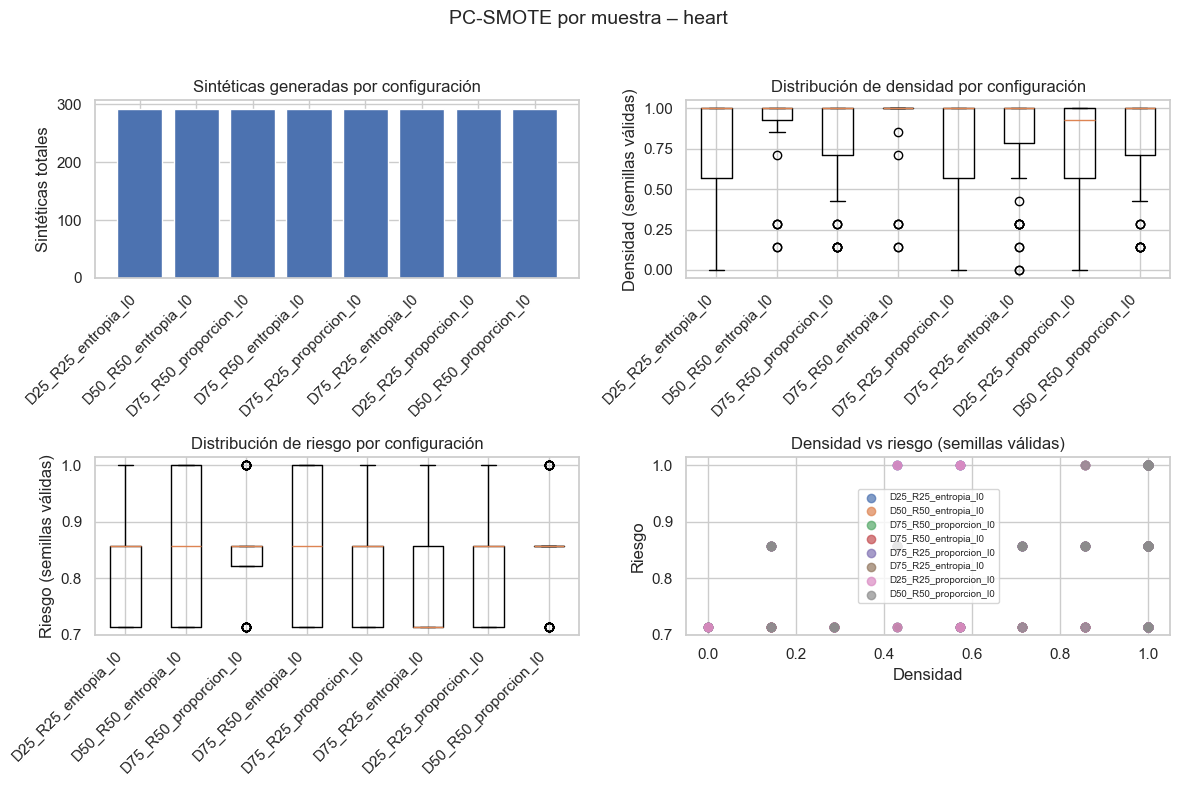

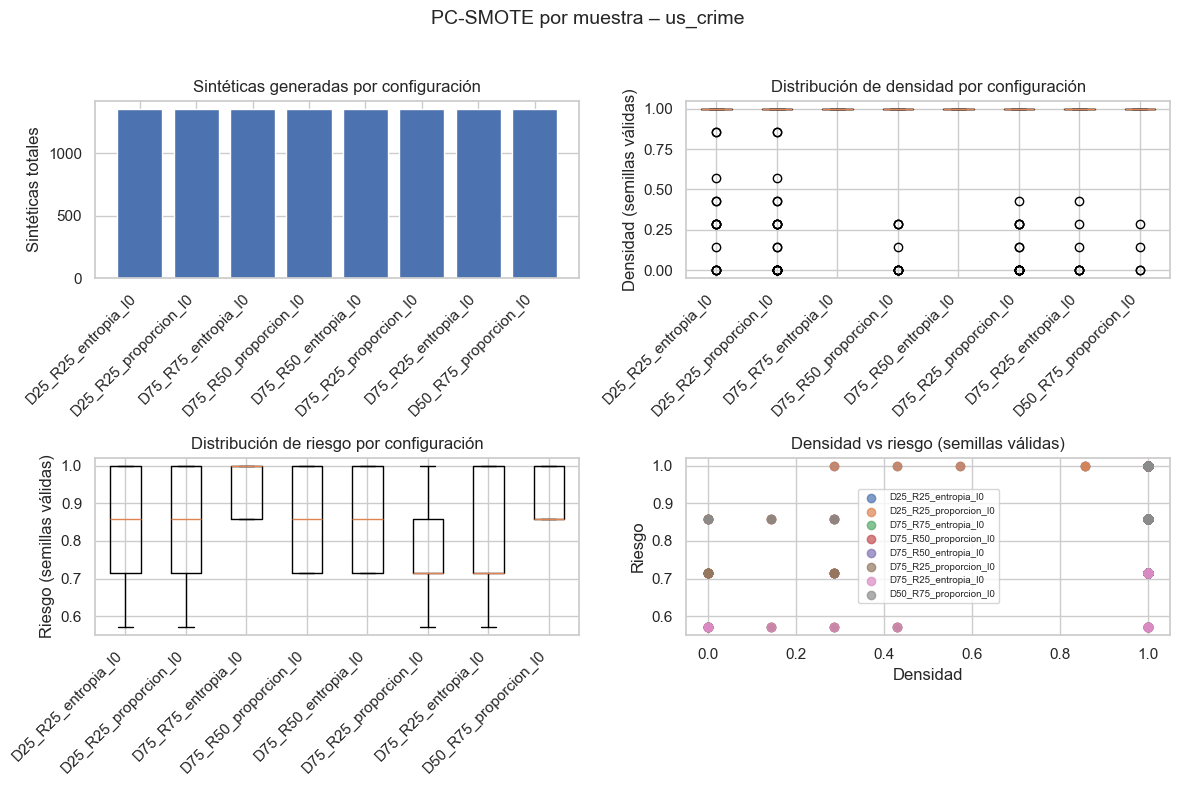

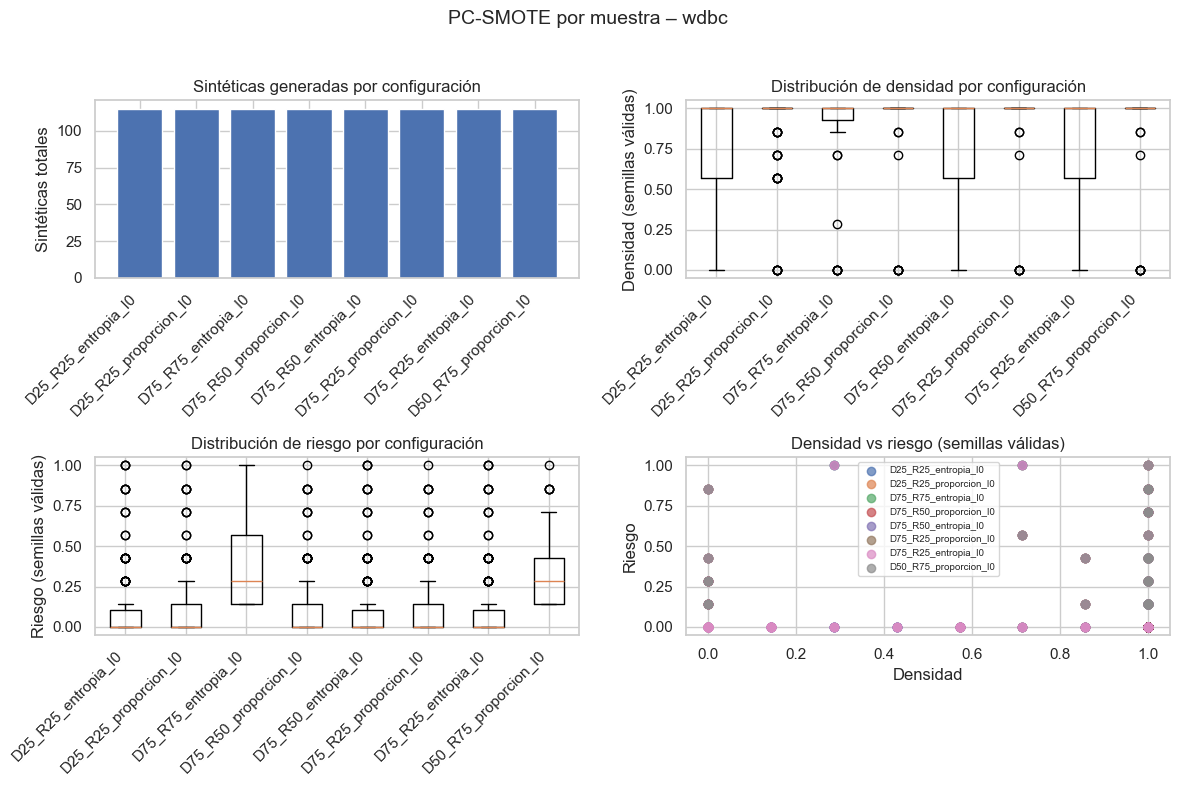

In [20]:
for ds in df_logs["dataset"].unique():
    sub = df_logs[df_logs["dataset"] == ds]
    print(f"\n=== Dataset: {ds} ===")
    generar_panel_por_dataset(sub, ds, guardar=True)


💾 Guardado panel_pcsmote_wdbc.png


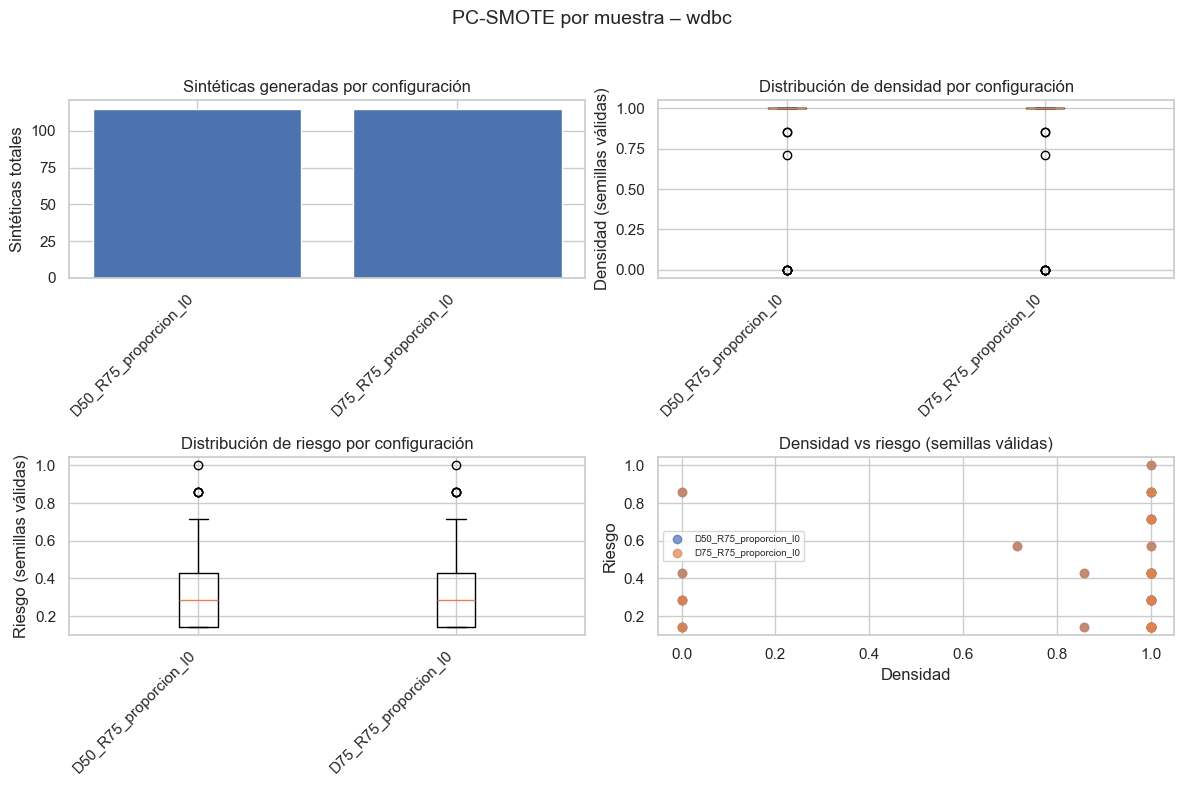

In [21]:
df_wdbc = df_logs[df_logs["dataset"] == "wdbc"].copy()

configs_raras = [
    "D50_R75_proporcion_I0",
    "D75_R75_proporcion_I0",
]

fig = generar_panel_por_dataset(df_wdbc, "wdbc",
                                configs_interes=configs_raras,
                                guardar=True)
